# Some machine learning with SDSS data

I decided to follow parts of a [previous AstroHackWeek demo](https://github.com/AstroHackWeek/AstroHackWeek2016/blob/master/day2-machine-learning/machine-learning-on-SDSS.ipynb) by J. S. Bloom (2014, 2016).

This workbook is for a discussion about starting out with ML methods, but the results we get are problematic from a physics perspective for multiple reasons (some of which we discuss).

We're going to use data from the [SDSS skyserver SQL server](http://skyserver.sdss3.org/public/en/tools/search/sql.aspx). For more information on this data I found a [terse description of the fields in the table](http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+SpecPhoto+V
) and [some details of the preprocessing](http://skyserver.sdss.org/dr1/en/help/docs/algorithm.asp). An example query (you won't have to do this yourself) to get two types of photometry (aperature and petrosian), corrected for extinction, for 1000 QSO sources with redshifts:

```
SELECT *,dered_u - mag_u AS diff_u, dered_g - mag_g AS diff_g, dered_r - mag_r AS diff_g, dered_i - mag_i AS diff_i, dered_z - mag_z AS diff_z from
(SELECT top 1000
objid, ra, dec, dered_u,dered_g,dered_r,dered_i,dered_z,psfmag_u-extinction_u AS mag_u,
psfmag_g-extinction_g AS mag_g, psfmag_r-extinction_r AS mag_r, psfmag_i-extinction_i AS mag_i,psfmag_z-extinction_z AS mag_z,z AS spec_z,dered_u - dered_g AS u_g_color, 
dered_g - dered_r AS g_r_color,dered_r - dered_i AS r_i_color,dered_i - dered_z AS i_z_color,class
FROM SpecPhoto 
WHERE 
 (class = 'QSO')
 ) as sp
```

J. S. Bloom already ran some queries like this and saved them as `csv`, and removed the first line containing `#Table` from the file. The next cell will download one of these files, with data from 10,000 QSO sources:

In [22]:
import os
if os.path.exists('qso10000.csv'):
    print('Have already downloaded data.')
else:
    os.system('wget https://gist.githubusercontent.com/anonymous/53781fe86383c435ff10/raw/4cc80a638e8e083775caec3005ae2feaf92b8d5b/qso10000.csv')

Have already downloaded data.


## First look at the data

In [23]:
import pandas as pd
pd.set_option('display.max_columns', None)

qso = pd.read_csv('qso10000.csv', index_col=0)
print(qso.columns) # to see all column names without scrolling before looking at sample of table
qso.head()

Index(['ra', 'dec', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z',
       'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'spec_z', 'u_g_color',
       'g_r_color', 'r_i_color', 'i_z_color', 'class', 'diff_u', 'diff_g',
       'diff_g1', 'diff_i', 'diff_z'],
      dtype='object')


,ra,dec,dered_u,dered_g,dered_r,dered_i,dered_z,mag_u,mag_g,mag_r,mag_i,mag_z,spec_z,u_g_color,g_r_color,r_i_color,i_z_color,class,diff_u,diff_g,diff_g1,diff_i,diff_z
objid,,,,,,,,,,,,,,,,,,,,,,,
1237648720142532813,146.90229,-0.984913,19.64289,19.31131,19.25328,19.15353,19.13345,19.71604,19.37595,19.32818,19.24847,19.21259,0.652417,0.331583,0.058027,0.099751,0.020077,QSO,-0.073151,-0.064648,-0.074903,-0.094942,-0.079136
1237658425156829371,142.45853,6.646406,19.39569,19.34811,19.16626,18.93152,19.06013,19.40327,19.36566,19.18335,18.94222,19.08077,1.537123,0.047575,0.181847,0.234743,-0.128612,QSO,-0.007589,-0.017550,-0.017090,-0.010700,-0.020636
1237660413189095710,143.15770,8.175363,19.10362,18.88904,18.70672,18.58508,18.61328,19.11102,18.88857,18.70458,18.57886,18.62583,1.467101,0.214582,0.182318,0.121645,-0.028202,QSO,-0.007397,0.000473,0.002148,0.006218,-0.012548
1237660412651962520,142.49264,7.800945,19.88820,19.75146,19.52941,19.65000,19.52470,19.88709,19.75292,19.53512,19.67052,19.50256,1.014217,0.136745,0.222052,-0.120590,0.125301,QSO,0.001118,-0.001457,-0.005716,-0.020527,0.022139
1237658493336944662,142.64367,7.917698,18.45897,18.40651,18.15901,17.77130,17.75986,18.55725,18.55002,18.40316,18.01008,18.03100,0.215603,0.052462,0.247498,0.387709,0.011444,QSO,-0.098282,-0.143515,-0.244150,-0.238779,-0.271137


**We'll be predicting redshift 'spec_z' from the photometry data.**

Following Bloom we'll end up dropping the position on the sky 'ra' and 'dec'.

If we're interested in the relationship between photometry and redshift, the location on the sky shouldn't be relevant. Except that if the corrections to contamination that varies of the sky hasn't been done properly, there could be "signal" there. Seeing if an ML method can do something with 'ra' and 'dec' might be interesting for detecting problems in the data. But for now, we'll assume that's not what we want to do.

But before discarding 'ra' and 'dec', we'll make a quick plot of the 'ra' values in the order they appear in the table:

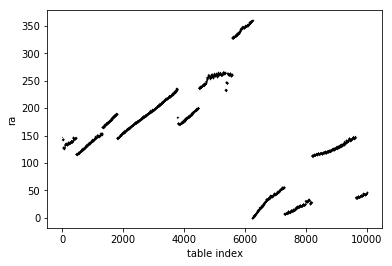

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(qso['ra'].values, 'k.', ms=0.5)
plt.xlabel('table index'); plt.ylabel('ra');

The data is not in a random order. If first learning about machine learning and trying out methods, my recommendation is to default to using randomly shuffled data. A good default for some machine learning methods (e.g., when using mini-batch optimizers for neural networks) is to use random examples. Also, when we later split the data into train/validation/test sets, we may want the training set 'ra' values to be representative of what we'll see in 'future' at validation time. Again, *if we're first doing machine learning*, having the validation and testing sets come from different distributions adds a complication we probably want to avoid.

However, if we were interested in seeing how well a system could forecast into the future, we may want to take the validation and test sets from the end of a dataset (if gathered as a time series). So we would split up the data into train/validation/test before shuffling the training set.

In this example, we do *not* have a representative sample of the SDSS data! If you download the data for 500,000 QSO sources and rerun this notebook, you'll find that the validation performance gets a lot worse, far outside our error bars :-(. So really we want to shuffle all of SDSS's data before subsampling and splitting, rather than shuffling within the top 10,000 results that SDSS returned.

When I shuffle the data I clamp the random seed to make this study reproducible and stable. Normally I would put data selection in a separate file and save out the results. My analysis code would then definitely load the same data every time. If we wanted to see the sensitivity of methods to dataset choice, we could change the seed.

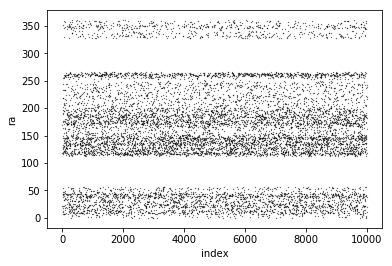

In [25]:
import numpy as np
qso = qso.iloc[np.random.RandomState(seed=12345).permutation(len(qso))]
plt.plot(qso['ra'].values, 'k.', ms=0.5)
plt.xlabel('index'); plt.ylabel('ra');

## Setting up the output to predict

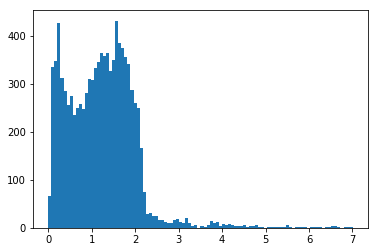

In [26]:
# We want to predict redshifts:
plt.hist(qso['spec_z'], 100, histtype='stepfilled');

My knee-jerk reaction for a quantity that's positive, skewed, and has a big range, is to take logs. It's not always the right thing to do, but is often a good idea.

Taking logs of the output means the machine learning method cares about relative errors in its predictions rather than absolute red-shifts. I'll let the astronomers decide if that makes sense...

If you're not sure whether to take the log of an input, you can always add both the original feature and its transformed version to your table. Let the machine learning method decide how to use them!

In [27]:
# If you download more data some redshifts can be -ve!
# For example, Andromeda is moving towards us.
# I hackily make all the numbers +ve so I can take logs.
if qso['spec_z'].min() < 0:
    qso['spec_z'] += 2*abs(qso['spec_z'].min())

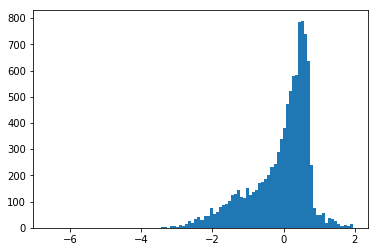

In [28]:
# Or maybe *log* redshifts...
import numpy as np
qso_y = np.log(qso['spec_z'])
plt.hist(qso_y, 100, histtype='stepfilled');

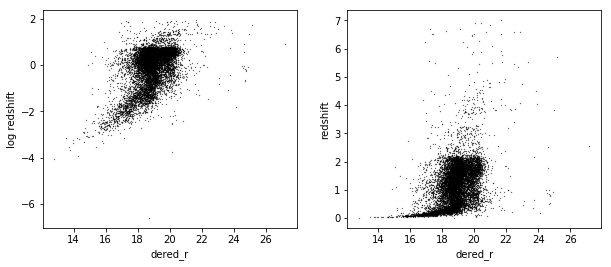

In [29]:
mask = qso['dered_r'] > -9000  # we'll see why shortly...
plt.figure(figsize=[10, 4]);
plt.subplot(1, 2, 1); plt.plot(qso['dered_r'][mask], qso_y[mask], 'k.', ms=0.5)
plt.xlabel('dered_r'); plt.ylabel('log redshift')
plt.subplot(1, 2, 2); plt.plot(qso['dered_r'][mask], np.exp(qso_y[mask]), 'k.', ms=0.5)
plt.xlabel('dered_r'); plt.ylabel('redshift');

I like the look of the log-redshift histogram a lot more, and the relationship to the `dered_r` input looks closer to linear and easier to model after log-transforming.

There is a sharp cut-off above red-shifts of ~2. That's sad of course, because we are most interested in predicting large red-shifts where it's harder to measure them! As we'll see, we're much worse at predicting these large red-shifts. We could consider putting model attention at larger red-shifts by subsampling the data at lower redshifts, or attaching higher importance to the examples at large red-shifts (if the machine learning method supports that). But really we would like more data at large red-shifts! And really we should inject more physics knowledge into the analysis...

## Setting up the inputs to predict from

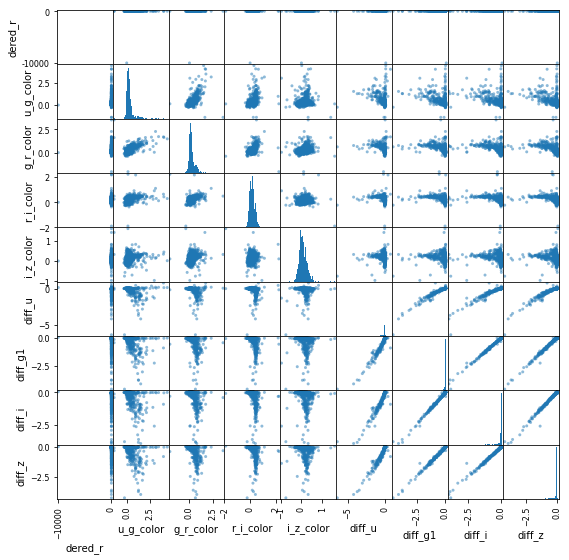

In [30]:
# What about the inputs?
column_subset = ['dered_r', 'u_g_color', 'g_r_color',
                 'r_i_color', 'i_z_color', 'diff_u', 'diff_g1', 'diff_i', 'diff_z']
pd.plotting.scatter_matrix(qso[:1000][column_subset], figsize=[9,9], hist_kwds={'bins': 100});

# I wanted to use DFM's corner here... nicer for publication output, but proved more of a pain to get working...

The distributions involving `dered_r` look weird because it has "missing values" indicated with -10000. These could be converted to missing values in the pandas data frame. Some machine learning methods (like XGBoost) have special missing value support, but most don't.

When there are only a few missing values (like here) the easiest thing to do is just throw out those rows (so we do). But in some problems many or even most rows contain a missing value somewhere. One fix is to set these values to zero (or a median value), and add another column for each original feature that contains zeros and ones, indicating whether the value is missing or not. The machine learning method can then learn what to do with missing values.

There are some fairly strong correlations between some of the features. In linear regression, "co-linear" features mean that it's hard to interpret the features. But if we "regularize" we can keep all these features, and it might be fine. In fact it might be better than throwing features away.

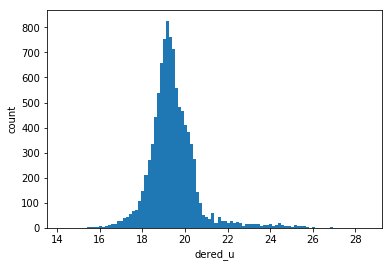

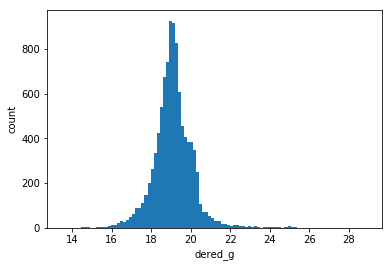

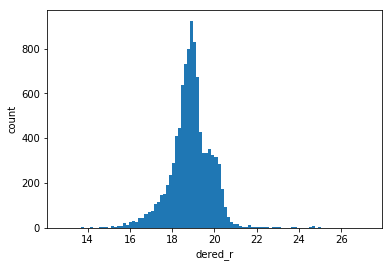

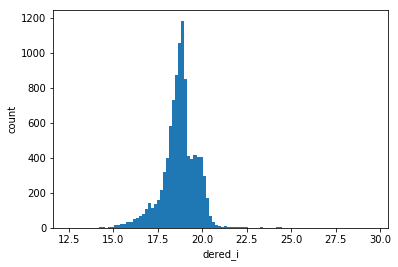

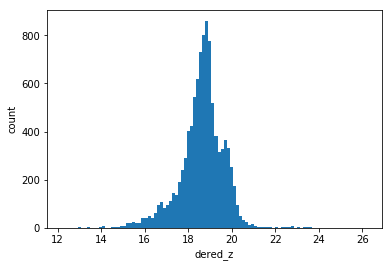

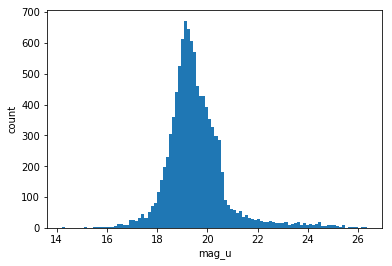

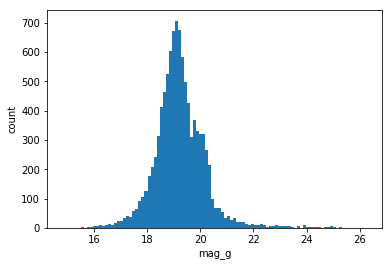

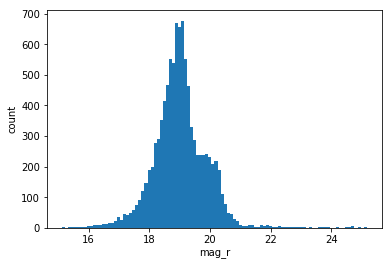

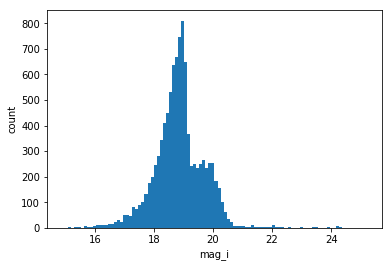

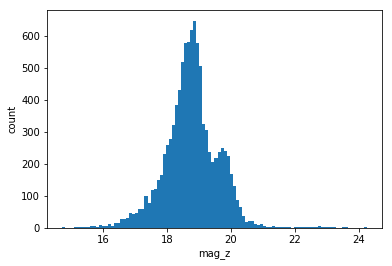

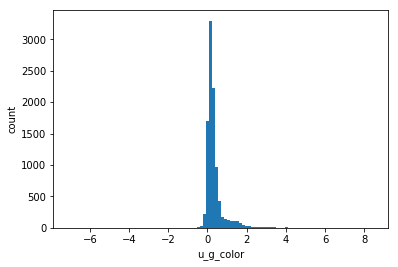

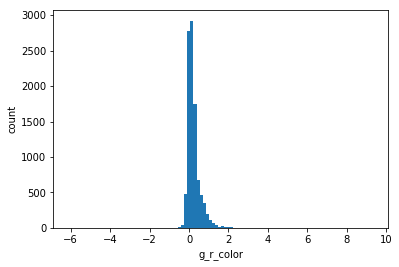

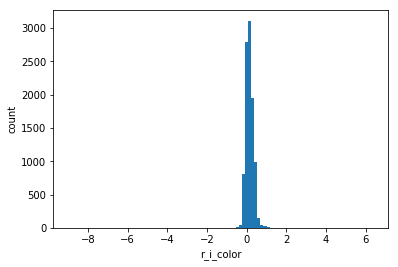

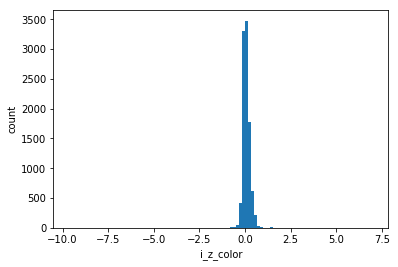

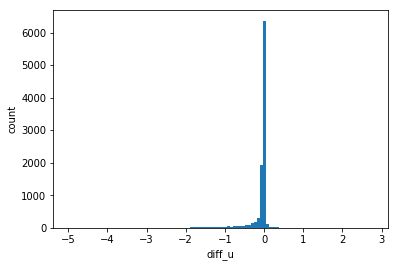

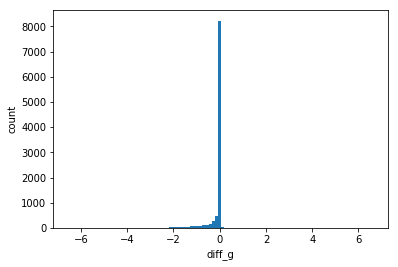

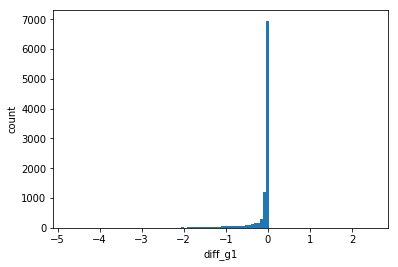

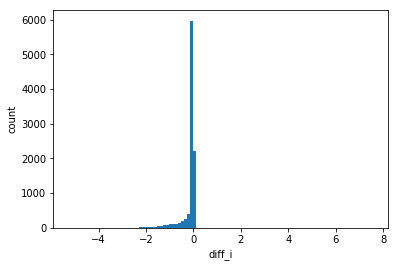

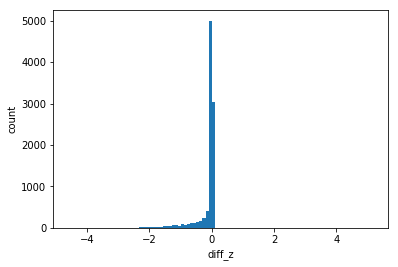

In [31]:
# Cut used previously by Bloom:
qso_X = qso.drop(columns=['ra', 'dec', 'class', 'spec_z'])
#qso_X = qso[column_subset]  # Bloom dropped many more features. Can debate whether should.
cut = (qso_X['dered_r'] > -9999) & (qso_X['g_r_color'] > -10) & (qso_X['g_r_color'] < 10) & (qso_X['diff_u'] > -5)
qso_X = qso_X[cut]
qso_y = qso_y[cut]

# I decided to inspect all of the histograms:
for col in qso_X.columns:
    plt.figure()
    plt.hist(qso_X[col], 100);
    plt.xlabel(col)
    plt.ylabel('count');

Some of the histograms look like they are made out of two bumps. Is there an obvious clustering that would be worth investigating?

The `diff_*` quantities look like they "should" be -ve. If they were I might take the log of minus these values. Also it makes me suspect the +ve values artifacts of previous data processing? The SQL statement said `... dered_z - mag_z AS diff_z ...`. Maybe positive `diff_*` quantities are unphysical. I haven't done anything further for now though.

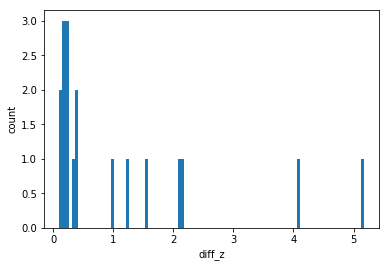

In [11]:
# Taking a look at the tail of diff_z
plt.hist(qso_X['diff_z'][qso_X['diff_z'] > 0.1], 100)
plt.xlabel('diff_z'); plt.ylabel('count');

I haven't, but in a first pass I'd consider discarding these large values. I'm tempted to force `diff_z` to be negative, and then use log(-diff_z) as a feature. (But I haven't.)

Looking at 84% of cases


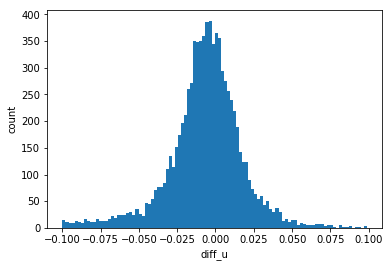

In [12]:
# Distribution on diff_u exceedingly sharp, but doesn't have "atom" at zero:
plt.hist(qso_X['diff_u'][abs(qso_X['diff_u']) < 0.1], 100)
plt.xlabel('diff_u'); plt.ylabel('count')
print('Looking at %0.0f%% of cases' % (100.0 * (abs(qso_X['diff_u']) < 0.1).sum() / len(qso_X)))

In [13]:
# Standardizing inputs. Often, but not always, a useful default.
qso_X = qso_X - qso_X.mean(axis=0).values
qso_X = qso_X / qso_X.std(axis=0).values

## Dataset splits

**This part is important.** We split our data into training, validation, and test splits.

Good training error might not mean anything: it's easy to get zero training error (e.g., nearest neighbour regression with K=1). Validation sets (AKA "development sets") let us compare different models. However, it's easy to fool-yourself (make a fool of yourself) by making many random tweaks – when we start to fit the validation by making many comparisons, it's no longer representative of future performance(†). A held out test set should be used *at the end* to do a final comparison, of a small number of alternatives.

(†) Here the validation set is not representative of future performance, because the 10,000 QSO's we have are not representative of the whole SDSS catalogue. We are probably also interested mainly in large red-shift sources.

In [14]:
N = len(qso_y)
N_val = int(N * 0.10)
N_test = int(N * 0.10)
N_train = N - N_val - N_test
qso_X_train = qso_X[:N_train]
qso_y_train = qso_y[:N_train]
qso_X_val = qso_X[N_train:(N_train + N_val)]
qso_y_val = qso_y[N_train:(N_train + N_val)]
# ...can fill in qso_X_test and qso_y_test when I need them...

## Fit some models

val error = 0.511 +/- 0.165
train error = 0.374 +/- 0.013


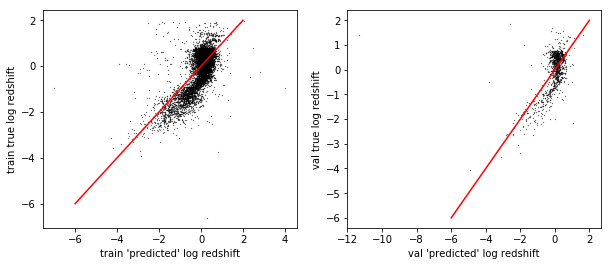

In [15]:
import scipy.stats
def mse_stderr(y1, y2):
    r2 = (y1 - y2) ** 2
    return np.mean(r2), scipy.stats.sem(r2)
    
y_train_true = qso_y_train.values
y_val_true = qso_y_val.values

def fit_and_evaluate(model):
    model.fit(qso_X_train, qso_y_train)
    y_val_pred = model.predict(qso_X_val)
    y_train_pred = model.predict(qso_X_train)
    
    plt.figure(figsize=[10,4])
    plt.subplot(1, 2, 1)
    plt.plot(y_train_pred, y_train_true, '.k', ms=0.5)
    plt.plot([-6, 2], [-6, 2], '-r')
    plt.xlabel("train 'predicted' log redshift"); plt.ylabel("train true log redshift");
    plt.subplot(1, 2, 2)
    plt.plot(y_val_pred, y_val_true, '.k', ms=0.5)
    plt.plot([-6, 2], [-6, 2], '-r')
    plt.xlabel("val 'predicted' log redshift"); plt.ylabel("val true log redshift");
    
    print('val error = %0.3f +/- %0.3f' % mse_stderr(y_val_true, y_val_pred))
    print('train error = %0.3f +/- %0.3f' % mse_stderr(y_train_true, y_train_pred))
    
    return y_val_pred

import sklearn.linear_model
fit_and_evaluate(sklearn.linear_model.Ridge(alpha=10.0));

From the plots it looks like the predictions are working similarly on the two datasets. The plots mainly look different because there are many more points in the training set than the validation set.

Our predictions are worse on the validation examples than the training examples. That is common, and not necessarily a sign of over-fitting. Although it is a sign we could learn more.

There is a clear sign of under-fitting. If we systematically increased the predictions where we're currently predicting log-redshifts of less than zero, we'd perform better. We need a non-linear predictor. We could do that by taking non-linear functions of our inputs and adding columns to our data matrix. But instead we'll try another regression method...

val error = 0.245 +/- 0.034
train error = 0.000 +/- 0.000


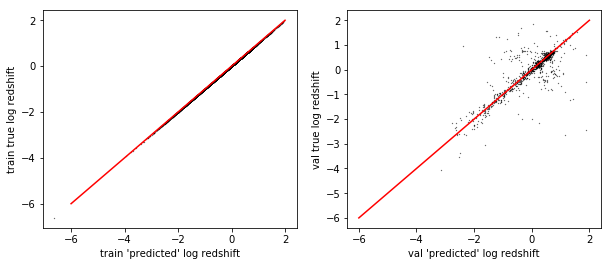

In [16]:
import sklearn.tree
fit_and_evaluate(sklearn.tree.DecisionTreeRegressor());

Now we probably are overfitting: we have memorized the training set, and we know the red-shift observations are noisy. However, we are generalizing to unseen examples. Our validation error is lower than before. I would prefer this model to the linear regression one.

After reading the documentation I tweak one of the hyper-parameters of the method to stop it from matching the training set so closely. I also try ensembling different models into a "random forest".

val error = 0.169 +/- 0.019
train error = 0.133 +/- 0.007


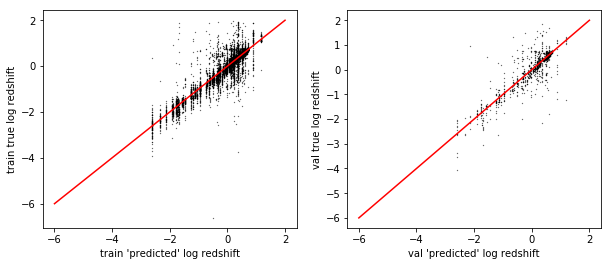

In [17]:
import sklearn.tree
val_pred_single_tree = fit_and_evaluate(sklearn.tree.DecisionTreeRegressor(min_samples_leaf=50));

val error = 0.135 +/- 0.015
train error = 0.027 +/- 0.002


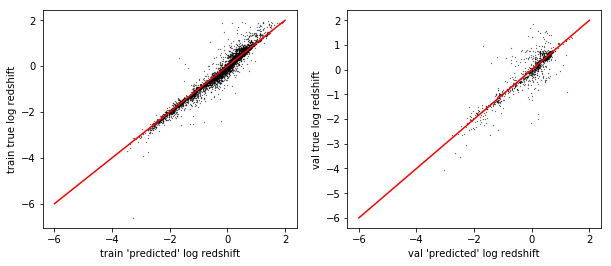

In [18]:
# The version of sklearn I have installed calls something that's going to be deprecated from Numpy.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sklearn.ensemble
val_pred_ensemble = fit_and_evaluate(sklearn.ensemble.RandomForestRegressor(10));

These restricted or ensembled decision trees seem to be working a bit better. However, you may not be convinced given how big the error bars on the validation performance are.

Below we do a *paired comparison*. We look at the difference in square error between the two methods on each example. It looks like ensembling did help (but if we computed a p-value from a t-test, it wouldn't be *tiny*). Also, we have only showed that this particular ensemble fit is generalizing better. To look at how robust the ensembling procedure is, we'd have to run it multiple times. We are also not looking at how robust the methods are on different datasets: we could re-partition our data to assess that. Before reporting an "error-bar" on a result, we need to be clear why we want one – what question we are asking.

In [19]:
ensemble_losses = (val_pred_ensemble - y_val_true)**2
single_tree_losses = (val_pred_single_tree - y_val_true)**2

differences = single_tree_losses - ensemble_losses
print('ensemble better by %0.3f +/- %0.3f' % (differences.mean(), scipy.stats.sem(differences)))

ensemble better by 0.035 +/- 0.010


## Understanding the residuals

When points lie close to a diagonal line, it's often good to subtract off the diagonal so that we use more of the area of the plot.

In the plot below I show the errors made as a function of observed (rather than predicted) red-shift. We see that we are systematically under-estimating large red-shifts. However, unlike the discussion under the linear regression plot, there is no easy fix here. If we systematically increase our large estimates, we'll spuriously predict large red-shifts for many examples. The plots above this section didn't show any obvious bias that we can correct.

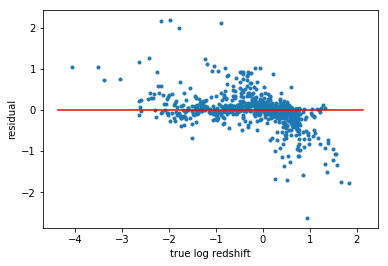

In [20]:
plt.plot(y_val_true, val_pred_ensemble - y_val_true, '.')
plt.plot(plt.xlim(), [0,0], 'r-')
plt.xlabel('true log redshift'); plt.ylabel('residual');

As a first step to understanding whether we could improve things, I invent a classification task. I fit a model to predict whether the log-redshift is bigger than a threshold.

Although on the training set the classifier separates out large-redshifts, it is unable to confidently do so on the validation set. If a model can't be certain a red-shift is large, it has to hedge its bets and predict a moderate value. Sadly I think we need more data and/or more knowledge injected into the analysis. I doubt escalating to more advanced ML methods will help here. (Also, again, we need a more representative dataset!)

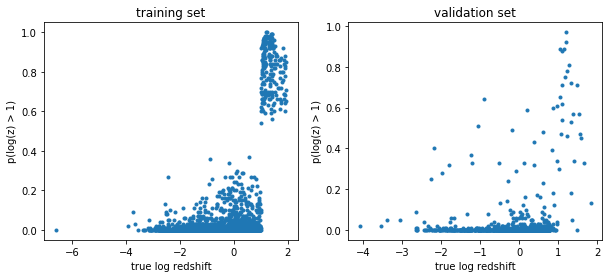

In [21]:
#model = sklearn.linear_model.LogisticRegression(C=(1 / 10.0))
model = sklearn.ensemble.RandomForestClassifier(100)
threshold = 1.0
model.fit(qso_X_train, qso_y_train > threshold)

y_train_pred = model.predict_proba(qso_X_train)[:,1]
y_val_pred = model.predict_proba(qso_X_val)[:,1]

plt.figure(figsize=(10,4))
plt.clf()
plt.subplot(1, 2, 1)
plt.title('training set');
plt.plot(y_train_true, y_train_pred, '.')
plt.xlabel('true log redshift'); plt.ylabel('p(log(z) > %g)' % threshold)
plt.subplot(1, 2, 2)
plt.title('validation set')
plt.plot(y_val_true, y_val_pred, '.');
plt.xlabel('true log redshift'); plt.ylabel('p(log(z) > %g)' % threshold);